In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from google.colab import drive
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
data_dir = '/content/drive/MyDrive/data_no_preprocess'

In [3]:
data = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/data_no_preprocess',
    image_size=(512, 512)  # Change the size of images to 512x512
)


Found 2850 files belonging to 4 classes.


In [4]:
for images, labels in data.take(1):
    image_shape = images.shape[1:]

# Show the properties of the dataset
print("Class names:", data.class_names)
print("Image shape:", image_shape)
print("Number of classes:", len(data.class_names))
print("Number of batches:", data.cardinality().numpy())


Class names: ['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']
Image shape: (512, 512, 3)
Number of classes: 4
Number of batches: 90


In [5]:
data_iterator = data.as_numpy_iterator()

In [6]:
batch = data_iterator.next()

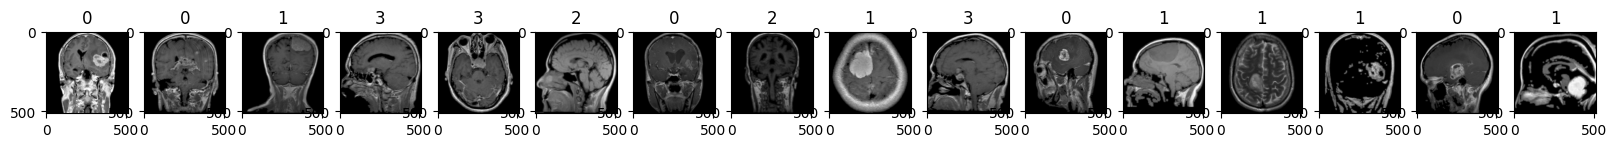

In [7]:
fig, ax = plt.subplots(ncols=16, figsize=(20,20))
for idx, img in enumerate(batch[0][:16]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [8]:
batch[0].max()


255.0

In [9]:
data.map(lambda x,y: (x/255 , tf.one_hot(y, depth=4)))
# data = data.map(lambda x, y: (x / 255.0, tf.expand_dims(y, axis=-1)))  # Expand dimensions for (batch_size, height, width, 1)


<_MapDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [10]:
data.as_numpy_iterator().next()

(array([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],
 
 
        [

In [11]:
len(data)
train_size = int(len(data)*.7)
val_size = int(len(data)*.1)
test_size = int(len(data)*.2)

In [12]:
train_data = data.take(train_size)
val_data = data.skip(train_size).take(val_size)
test_data = data.skip(train_size + val_size).take(test_size)

In [26]:
# Create a sequential model
model = models.Sequential()

# Rescale the input images
model.add(layers.Rescaling(1./255, input_shape=(512, 512, 3)))

# Add convolutional and pooling layers with ReLU activation
model.add(layers.Conv2D(16, (5, 5), strides=1, activation='relu'))  # Conv layer 1
model.add(layers.BatchNormalization())  # Batch Norm layer 1
model.add(layers.MaxPooling2D())  # Pooling layer 1

model.add(layers.Conv2D(32, (5, 5), strides=1, activation='relu'))  # Conv layer 2
model.add(layers.BatchNormalization())  # Batch Norm layer 2
model.add(layers.MaxPooling2D())  # Pooling layer 2

model.add(layers.Conv2D(64, (3, 3), strides=1, activation='relu'))  # Conv layer 3
model.add(layers.BatchNormalization())  # Batch Norm layer 3
model.add(layers.MaxPooling2D())  # Pooling layer 3

model.add(layers.Conv2D(128, (3, 3), strides=1, activation='relu'))  # Conv layer 4
model.add(layers.BatchNormalization())  # Batch Norm layer 4
model.add(layers.MaxPooling2D())  # Pooling layer 4

# Flatten the output for the dense layers
model.add(layers.Flatten())

# Add fully connected layers
model.add(layers.Dense(512, activation='relu'))  # Fully connected layer 1
model.add(layers.Dropout(0.5))  # Dropout layer 1

model.add(layers.Dense(256, activation='relu'))  # Fully connected layer 2
model.add(layers.Dropout(0.5))  # Dropout layer 2

model.add(layers.Dense(128, activation='relu'))  # Fully connected layer 3
model.add(layers.Dense(4, activation='softmax'))  # 4 classes

#Summary of the model
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 512, 512, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 508, 508, 16)        │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 508, 508, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 254, 254, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 250, 250, 32)        │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 250, 250, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 125, 125, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 123, 123, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 123, 123, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 61, 61, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 59, 59, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 59, 59, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 29, 29, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 107648)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │      55,116,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 55,388,388 (211.29 MB)

 Trainable params: 55,387,908 (211.29 MB)

 Non-trainable params: 480 (1.88 KB)

In [28]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [29]:
logdir='logs'

In [30]:
tensorboard_callback = TensorBoard(log_dir='./logs')
early_stopping_callback = EarlyStopping(patience=3, restore_best_weights=True)

In [31]:
hist = model.fit(train_data, epochs=15, validation_data=test_data, batch_size=32, callbacks=[tensorboard_callback])

Epoch 1/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 54s 599ms/step - accuracy: 0.3670 - loss: 19.2443 - val_accuracy: 0.2865 - val_loss: 5.2580
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 70s 604ms/step - accuracy: 0.3541 - loss: 9.1307 - val_accuracy: 0.2170 - val_loss: 4.1291
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 30s 484ms/step - accuracy: 0.3516 - loss: 3.8283 - val_accuracy: 0.2413 - val_loss: 3.7548
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 37s 606ms/step - accuracy: 0.3921 - loss: 2.2396 - val_accuracy: 0.3385 - val_loss: 1.8314
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 58s 946ms/step - accuracy: 0.3799 - loss: 1.8866 - val_accuracy: 0.2899 - val_loss: 2.5482
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 30s 478ms/step - accuracy: 0.3695 - loss: 1.7779 - val_accuracy: 0.3438 - val_loss: 1.4985
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 39s 635ms/step - accuracy: 0.4035 - loss: 1.8656 - val_accuracy: 0.1562 - val_loss: 2.3187
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 34s 552ms/step - accuracy: 0.4266 - loss: 1.6313 - val_acc

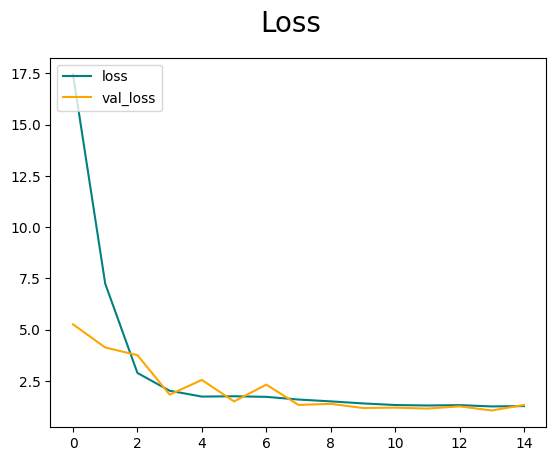

In [32]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

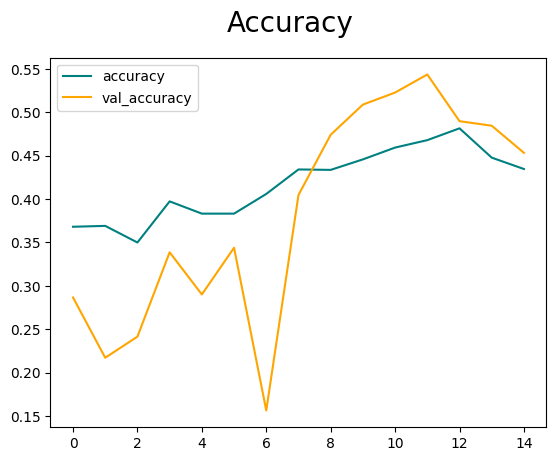

In [33]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [20]:
model.save('/content/drive/MyDrive/Project/712_rebuild_no.h5')